# 1. Datos y modelamiento

## 1.1 Importar librerías

In [2]:
!pip install yfinance --upgrade --no-cache-dir
!pip install pandas-datareader --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [3]:
#import
import tensorflow as tf

#univariate one step problem with lstm
from numpy import array
from tensorflow.keras.models import Sequential # Import from tensorflow.keras
from tensorflow.keras.layers import Dense,  LSTM # Import from tensorflow.keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import from tensorflow.keras

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## 1.2 Obtener datos

In [ ]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'
META='META'

META = yf.download("META", start, end)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
META.head()

Ticker,META
Date,
2016-05-02,118.013802
2016-05-03,116.879150
2016-05-04,117.506187
2016-05-05,117.257370
2016-05-06,118.929482


In [ ]:
import pandas
#pasamos a data frame los datos
dt= pandas.DataFrame(META)
dt.head()

Ticker,META
Date,
2016-05-02,118.013802
2016-05-03,116.879150
2016-05-04,117.506187
2016-05-05,117.257370
2016-05-06,118.929482


## 1.3 Visualización de la serie

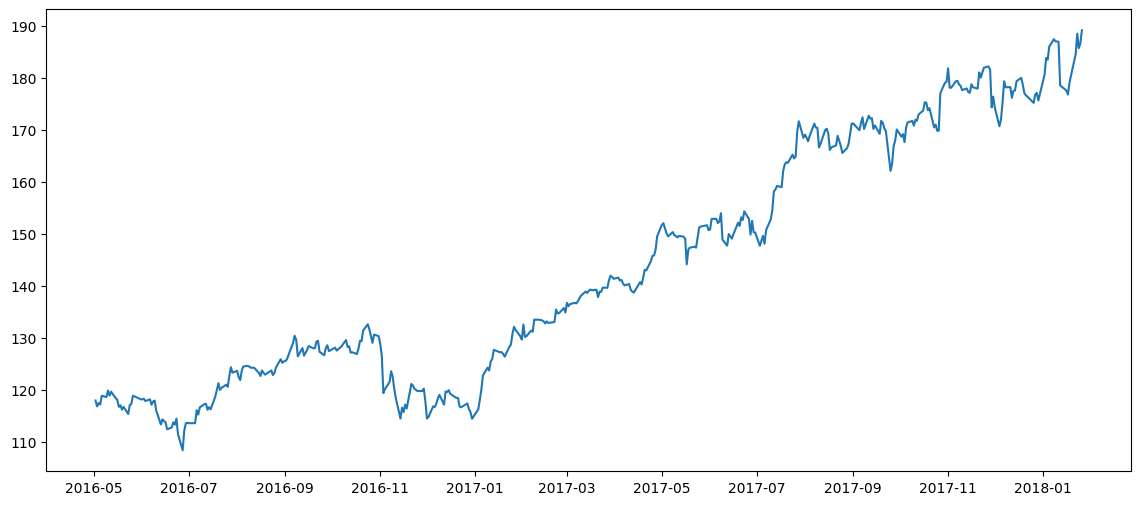

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(dt)

# 2. Modelos

## 2.1. LSTM

### 2.1.1. Procesamiento de los datos

In [ ]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

In [ ]:
#Ahora, a numpy array:
dt2= META.to_numpy()
dt2

array([[118.01380157],
       [116.87915039],
       [117.50618744],
       [117.25737   ],
       [118.92948151],
       [118.6806488 ],
       [119.93475342],
       [118.95934296],
       [119.71577454],
       [119.24797821],
       [118.11332703],
       [116.7995224 ],
       [117.09812164],
       [116.26205444],
       [116.7995224 ],
       [115.42599487],
       [117.14787292],
       [117.33699036],
       [118.90957642],
       [118.81999969],
       [118.25267792],
       [118.2228241 ],
       [118.37210846],
       [117.91426849],
       [118.2327652 ],
       [117.20760345],
       [117.8346405 ],
       [118.00383759],
       [116.07295227],
       [113.41545868],
       [114.40083313],
       [114.06242371],
       [113.85340118],
       [112.48982239],
       [112.8381958 ],
       [113.84346008],
       [113.37566376],
       [114.54016876],
       [111.554245  ],
       [108.45883942],
       [112.17134094],
       [113.62448883],
       [113.743927  ],
       [113

In [ ]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))
close_data

array([[118.01380157],
       [116.87915039],
       [117.50618744],
       [117.25737   ],
       [118.92948151],
       [118.6806488 ],
       [119.93475342],
       [118.95934296],
       [119.71577454],
       [119.24797821],
       [118.11332703],
       [116.7995224 ],
       [117.09812164],
       [116.26205444],
       [116.7995224 ],
       [115.42599487],
       [117.14787292],
       [117.33699036],
       [118.90957642],
       [118.81999969],
       [118.25267792],
       [118.2228241 ],
       [118.37210846],
       [117.91426849],
       [118.2327652 ],
       [117.20760345],
       [117.8346405 ],
       [118.00383759],
       [116.07295227],
       [113.41545868],
       [114.40083313],
       [114.06242371],
       [113.85340118],
       [112.48982239],
       [112.8381958 ],
       [113.84346008],
       [113.37566376],
       [114.54016876],
       [111.554245  ],
       [108.45883942],
       [112.17134094],
       [113.62448883],
       [113.743927  ],
       [113

Luego, dividimos los datos utilizando un 5% para prueba y el restante para entrenamiento.

In [ ]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [ ]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(close_train))
print(len(close_test))

417
22


Ahora, se debe generar la estructura para entrenar el modelo supervisado. En este caso particular, se solicita: diseñar y entrenar la red con 200 nodos, la función de activación “relu”, epochs=30, función de perdida de ‘mse’, longitud de ventana de 10 yoptimizer='adam'.

In [ ]:
n_back = 10
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

### 2.1.2 Diseño y entrenamiento del modelo

In [ ]:
##Neural Net
#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
# Use model.fit instead of model.fit_generator
model.fit(train_generator, epochs=num_epochs, verbose=0)

In [ ]:
##Ajuste del modelo a los datos:
history = model.fit(train_generator, epochs=num_epochs, verbose=0)

In [ ]:
#Imprimimos gráfico de funión de pérdida acorde los epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
]

plot_layout = go.Layout(
        title='Training loss')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

### 2.1.3 Evaluación del modelo

In [ ]:
import pandas as pd
import plotly.graph_objects as go

In [ ]:
#Predicción en el set de prueba:
prediction = model.predict(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
#Checamos las fechas de cada segmento (ok)
print(f"Fecha de inicio en el test: {date_test[0]}")
print(f"Fecha de fin en el test:   {date_test[-1]}")
print(f"Rango completo de fechas: {dataindex[0]} → {dataindex[-1]}")

Fecha de inicio en el test: 2017-12-26 00:00:00
Fecha de fin en el test:   2018-01-26 00:00:00
Rango completo de fechas: 2016-05-02 00:00:00 → 2018-01-26 00:00:00


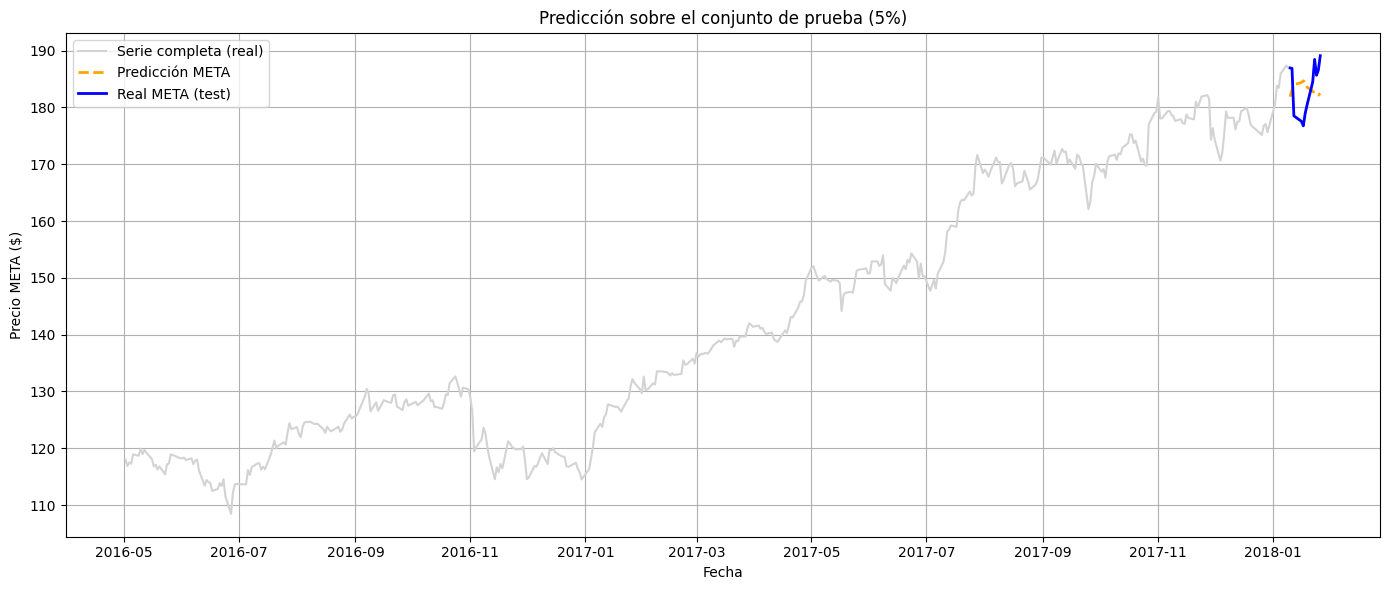

In [ ]:
plt.figure(figsize=(14, 6))

# 1. Serie original (entera, en gris)
plt.plot(dataindex, close_data, label='Serie completa (real)', color='lightgray')

# 2. Predicción en el test (Ajustamos el rango de fechas)
plt.plot(date_test[n_back:], prediction, label='Predicción META', linestyle='--', color='orange', linewidth=2)

# 3. Valores reales del test (Ajustamos el rango de fechas)
plt.plot(date_test[n_back:], close_test[n_back:], label='Real META (test)', color='blue', linewidth=2)

plt.title('Predicción sobre el conjunto de prueba (5%)')
plt.xlabel('Fecha')
plt.ylabel('Precio META ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculamos el RMSE
rmse = np.sqrt(mean_squared_error(close_test[n_back:], prediction))

# Calculamos el MAPE
mape = mean_absolute_percentage_error(close_test[n_back:], prediction)

print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

RMSE: 5.2646
MAPE: 0.0272


### 2.1.4 Predicción

In [ ]:
# 3] Asegurar que close_data esté en 1D ---
close_data = dt2.reshape(-1)

# 4] Definir predict() ---
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)
    return prediction_list[n_back-1:]

# --- [5] Generar forecast y graficar ---
forecast = predict(10, model)

In [ ]:
def predict_dates(num_prediction):
    last_date = dataindex[-1]
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction)

In [ ]:
forecast_dates = predict_dates(10)
forecast_dates

DatetimeIndex(['2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03',
               '2018-02-04', '2018-02-05'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
#Fechas, 10 días pegado al histórico:
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]

    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)

    return prediction_list[n_back-1:]  # solo forecast (sin la parte usada como entrada)

num_prediction = 10
forecast = predict(num_prediction, model)

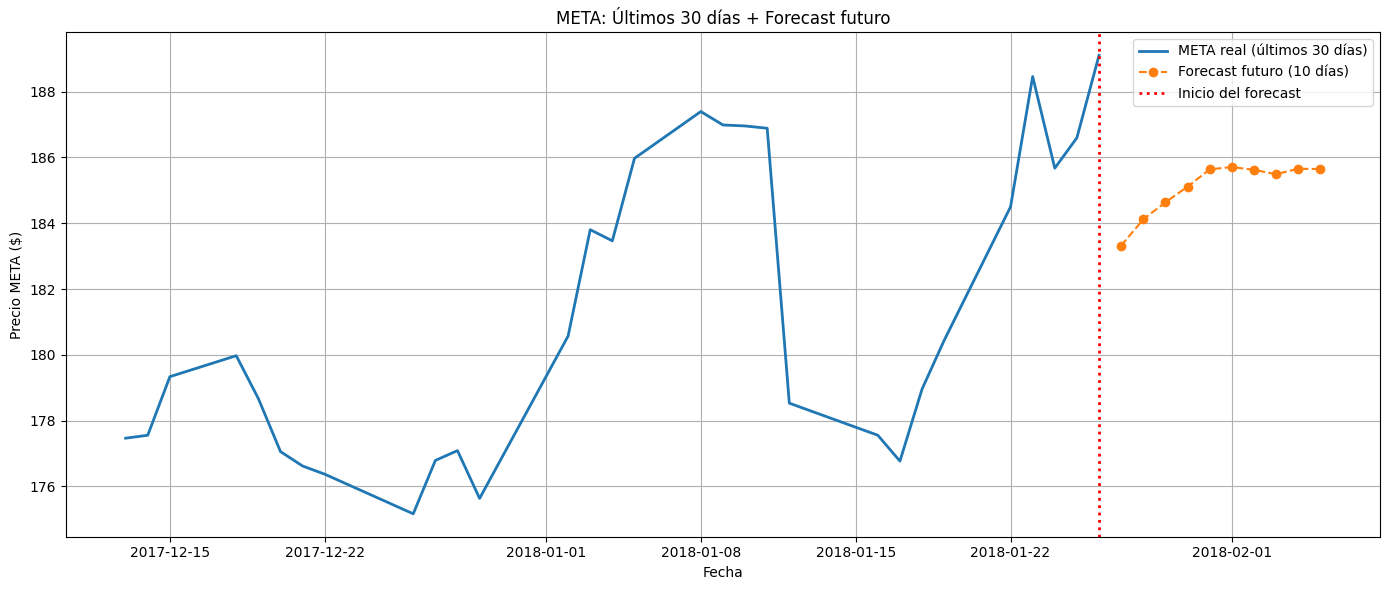

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Últimos 30 días históricos
n_recent = 30
recent_dates = dataindex[-n_recent:]
recent_values = close_data[-n_recent:]

# Asegurar forecast tenga longitud 10
forecast = forecast[-10:]  # por si tiene más
forecast_dates = forecast_dates[:10]  # asegurar que coincide

# Gráfico
plt.figure(figsize=(14, 6))

# 1. Últimos 30 días reales
plt.plot(recent_dates, recent_values, label='META real (últimos 30 días)', linewidth=2)

# 2. Forecast futuro
plt.plot(forecast_dates, forecast, label='Forecast futuro (10 días)', linestyle='--', marker='o')

# 3. Línea vertical: inicio del forecast
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

# Estética
plt.title('META: Últimos 30 días + Forecast futuro')
plt.xlabel('Fecha')
plt.ylabel('Precio META ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.2 Random Forest

In [4]:
!pip install ipykernel
!pip install skforecast
!pip install skforecast[full]
!pip install skforecast==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Manipulación datos:
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

In [2]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yf
#yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.1

### 2.2.1 Procesamiento de datos

In [ ]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'
META='META'

META = yf.download("META", start, end)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
#Pasamos a data frame los datos, cambiamos el nombre de la columna del tipo de precio a "y", para facilidad posterior.
dt= pandas.DataFrame(META)
df= dt.rename(columns={'META': 'y'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB


In [ ]:
# Preparación formato datos
# ==============================================================================
dataindex= pd.to_datetime(df.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

In [ ]:
# Damos formato de fecha con periodiciadad diaria a la serie.
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
df = df.asfreq('B')
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2016-05-02 to 2018-01-26
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [ ]:
## Imputamos algún valor faltante con el valor anterior.
df.fillna(method='bfill', inplace=True)

In [ ]:
# Podemos verificar si valores faltantes.
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [ ]:
#Especificamos primeramente el porcentje del corte.
steps = 22
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2016-05-02 00:00:00 --- 2017-12-27 00:00:00  (n=433)
Test dates  : 2017-12-28 00:00:00 --- 2018-01-26 00:00:00  (n=22)


### 2.2.2 Diseño y entrenamiento del modelo

In [ ]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-05-02 00:00:00'), Timestamp('2017-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-11 03:09:34 
Last fit date: 2025-05-11 03:09:34 
Skforecast version: 0.11.0

### 2.2.3 Evaluación del modelo

In [ ]:
# Pronóstico, en este caso elegimos una ventana de n-test días.
# ==============================================================================
steps = 22  ## el mismo que la ventana de test
predictions = forecaster.predict(steps=steps)
predictions.head(5)

,pred
2017-12-28,176.896388
2017-12-29,177.805304
2018-01-01,178.906911
2018-01-02,178.872269
2018-01-03,178.676295


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

error_mape = mean_absolute_percentage_error(
    y_true=data_test['y'],
    y_pred=predictions)

print(f"Test error (MAPE): {error_mape}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (MAPE): 0.0257633365043922
Test error (rmse): 5.956931373789199


### 2.2.4 Refinamiento

In [4]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 10
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10
             )
lags_grid = [10, 15]
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 19.52390374007665



In [5]:
# Visualizamos los resultados del grid search
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",19.523904,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 300}",19.552359,5,300
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",19.573610,5,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",19.739314,10,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 300}",19.759117,10,300
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",19.964655,10,500
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",21.479855,5,100
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 300}",21.623795,5,300
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",21.688621,5,500
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",22.360198,10,100


### 2.2.4 Predicción

In [ ]:
# Aplicar el modelo a la serie completa
regressor = RandomForestRegressor(max_depth= 5, n_estimators=100 , random_state=123)


forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
                )

forecaster.fit(y=df['y'])
f = forecaster.fit(y=df['y'])

In [ ]:
# Pronóstico, en este caso elegimos una ventana de 10 días.
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(5)

,pred
2018-01-29,185.794557
2018-01-30,185.052070
2018-01-31,183.640435
2018-02-01,182.551831
2018-02-02,180.365851


In [ ]:
fin = data_test.index.max()
fin

Timestamp('2018-01-26 00:00:00')

In [ ]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=10, freq='D').tolist()
fwd_dates

[Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-03 00:00:00'),
 Timestamp('2018-02-04 00:00:00')]

In [ ]:
## Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "META",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()